# Model Development

### Objective: create a Classifier to predict Marketing Interaction Outcomes

- Train and validate initial model
- Create SparkML Pipeline and save it to Object Store

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os
import sys
from pyspark.sql import SparkSession

spark = SparkSession\
    .builder\
    .appName("ModelDevelopment")\
    .config("spark.authenticate", "true")\
    .config("spark.hadoop.fs.s3a.s3guard.ddb.region","us-east-1")\
    .config("spark.yarn.access.hadoopFileSystems", "s3a://demo-aws-1")\
    .config("spark.hadoop.yarn.resourcemanager.principal",os.environ["HADOOP_USER_NAME"])\
    .getOrCreate()

#.master("local[*]")\
    
# **Note:** 
# Our file isn't big, so running it in Spark local mode is fine but you can add the following config 
# if you want to run Spark on the kubernetes cluster 
# 
# > .config("spark.yarn.access.hadoopFileSystems",os.getenv['STORAGE'])\

#.config("spark.authenticate", "true") \
#    .config("spark.yarn.access.hadoopFileSystems", os.environ['STORAGE'])

print("Spark Version: {}".format(spark.version))

Spark Version: 2.4.0.7.1.0.0-714


In [7]:
spark.sql("SELECT * FROM DEFAULT.CUSTOMER_INTERACTIONS_CICD LIMIT 10").show()

+-----------------+--------------------+-----------------+--------+------------+--------------------+-------+-------+-------------+---------+---------+-----------+-------+---------------+----------+----------+
|             NAME|      STREET_ADDRESS|             CITY|POSTCODE|PHONE_NUMBER|                 JOB|RECENCY|HISTORY|USED_DISCOUNT|USED_BOGO| ZIP_CODE|IS_REFERRAL|CHANNEL|          OFFER|CONVERSION|     SCORE|
+-----------------+--------------------+-----------------+--------+------------+--------------------+-------+-------+-------------+---------+---------+-----------+-------+---------------+----------+----------+
| Mrs. Erica Yates|4958 Nicholas Rid...|        Bowentown|   54416|        null|General practice ...|      8|    101|            1|        0|    Urban|          0|    Web|Buy One Get One|         0|0.81123763|
|       Juan Rojas|586 Richard Valle...|        Hollyberg|   19619|        null|         Chiropodist|      3|    386|            1|        0|Surburban|         

In [8]:
hist_DF = spark.sql("SELECT * FROM DEFAULT.CUSTOMER_INTERACTIONS_CICD")

In [9]:
hist_DF.dtypes

[('NAME', 'string'),
 ('STREET_ADDRESS', 'string'),
 ('CITY', 'string'),
 ('POSTCODE', 'int'),
 ('PHONE_NUMBER', 'int'),
 ('JOB', 'string'),
 ('RECENCY', 'int'),
 ('HISTORY', 'int'),
 ('USED_DISCOUNT', 'int'),
 ('USED_BOGO', 'int'),
 ('ZIP_CODE', 'string'),
 ('IS_REFERRAL', 'int'),
 ('CHANNEL', 'string'),
 ('OFFER', 'string'),
 ('CONVERSION', 'int'),
 ('SCORE', 'float')]

In [7]:
df = hist_DF.select("RECENCY", "HISTORY", "USED_DISCOUNT", "USED_BOGO", "ZIP_CODE", "IS_REFERRAL", "CHANNEL", "OFFER", "SCORE", "CONVERSION")

In [8]:
#Renaming target feature as "LABEL":
df = df.withColumnRenamed("CONVERSION","label")

In [10]:
cat_cols = [item[0] for item in df.dtypes if item[1].startswith('string')]
num_cols = [item[0] for item in df.dtypes if item[1].startswith('in')]

In [14]:
num_cols.remove('label')

In [37]:
#df.groupby("label").count().show()

#### Creating Pipeline
##### Notice the pipeline does not include the classifier. This is done on purpose so we can split it into two jobs.

In [38]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [39]:
def make_pipeline(df):        
    stages= []

    for col in cat_cols:

        stringIndexer = StringIndexer(inputCol = col , outputCol = col + '_StringIndex')
        encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[col + '_ClassVect'])
        stages += [stringIndexer, encoder]

    #Assembling mixed data type transformations:
    assemblerInputs = [c + "_ClassVect" for c in cat_cols] + num_cols
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

    stages += [assembler]

    #Creating and running the pipeline:
    pipeline = Pipeline(stages=stages)
    pipelineModel = pipeline.fit(df)
    out_df = pipelineModel.transform(df)
    
    return out_df, pipeline

In [40]:
out_df, pipeline = make_pipeline(df)

In [41]:
train, test = out_df.randomSplit([0.8, 0.2], seed=1)

In [44]:
from pyspark.ml.classification import RandomForestClassifier

In [45]:
rf = RandomForestClassifier()

In [46]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

In [47]:
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"),
                          numFolds=5)

In [48]:
# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train)

In [49]:
print(cvModel.avgMetrics)

[0.5414993578644028, 0.630617262385228, 0.5755649988060142, 0.6336760487783147, 0.5644201313357289, 0.635112587577211]


In [50]:
bestModel = cvModel.bestModel
print(bestModel)

RandomForestClassificationModel (uid=RandomForestClassifier_fff20c28ea35) with 30 trees


#### Test Set Evaluation

In [51]:
#Evaluating model with the held out test set:
prediction = cvModel.transform(test)

In [52]:
predictionAndTarget = prediction.select("label", "prediction")

In [53]:
# Create both evaluators
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName='areaUnderROC')

In [54]:
# Get metrics
acc = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})
auc = evaluator.evaluate(predictionAndTarget)

In [55]:
y_true = predictionAndTarget.select(['label']).collect()
y_pred = predictionAndTarget.select(['prediction']).collect()

In [56]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, roc_curve
cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     10885
           1       0.00      0.00      0.00      1892

    accuracy                           0.85     12777
   macro avg       0.43      0.50      0.46     12777
weighted avg       0.73      0.85      0.78     12777



/home/cdsw/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
from utils.cm import plot_conf_matrix

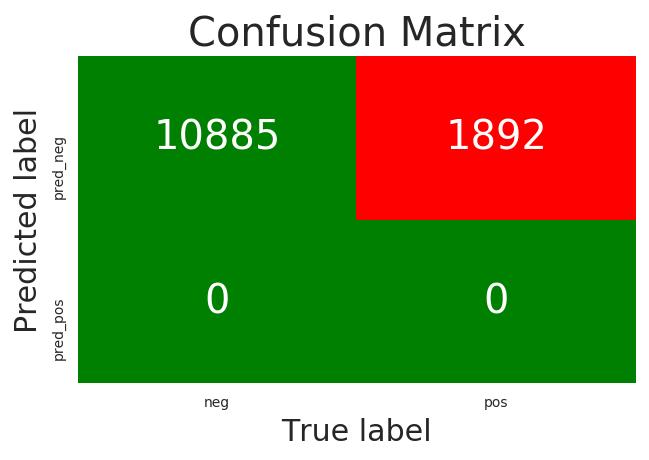

In [58]:
plot_conf_matrix(pd.DataFrame(cm.T, columns=['neg', 'pos'], 
                       index=['pred_neg', 'pred_pos']))

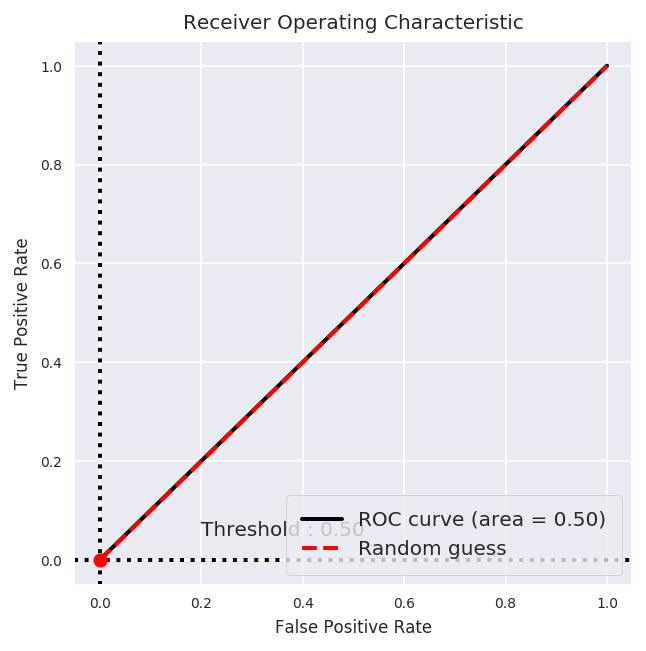

In [59]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(y_true, y_pred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

In [ ]:
#Printing metrics 
#print(acc)
#print(f1)
#print(weightedPrecision)
#print(weightedRecall)
#print(auc)

#### Saving Pipeline and Logistic Regression Model to Object Store

In [46]:
import datetime
import os, time

In [49]:
run_time_suffix = datetime.datetime.now()
run_time_suffix = run_time_suffix.strftime("%d%m%Y%H%M%S")

In [50]:
bestModel.write().overwrite().save("s3a://demo-aws-1/datalake/pdefusco/simple_cicd_models/bestLR_{}".format(run_time_suffix))
pipeline.write().overwrite().save("s3a://demo-aws-1/datalake/pdefusco/simple_cicd_models/pipeline_{}".format(run_time_suffix))

In [ ]:
#print("s3a://demo-aws-1/datalake/pdefusco/bestLR_{}".format(run_time_suffix))

In [ ]:
spark.stop()